In [9]:
import ast
import json
import pickle
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from itertools import chain
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

### Read data

In [2]:
# Load the pickled list
with open("/Utilisateurs/umushtaq/emotion_analysis_comics/incontext_learning/results/icl_llama-3-8b-Instruct-bnb-4bit/results_10.pickle", 'rb') as f:
    
    results = pickle.load(f)

In [3]:
all_labels = ["anger", "surprise", "fear", "disgust", "sadness", "joy", "neutral"]

In [4]:
grounds = results['ground_truths']
predictions = results['predictions']

In [5]:
def labels_to_binary_matrix(label_list, all_labels):
    binary_matrix = np.zeros((len(label_list), len(all_labels)))
    
    for i, labels in enumerate(label_list):
        for label in labels:
            if label in all_labels:
                binary_matrix[i][all_labels.index(label)] = 1
                
    return binary_matrix

def opposite(component_type):

    if component_type == "anger":
        return "surprise"
    elif component_type == "disgust":
        return "joy"
    elif component_type == "fear":
        return "sadness"
    elif component_type == "sadness":
        return "anger"
    elif component_type == "surprise":
        return "disgust"
    elif component_type == "joy":
        return "fear"
    elif component_type == "Neutral":
        return "sadness"
    

def harmonize_preds(grounds, preds):

    l1, l2 = len(preds), len(grounds)
    if l1 < l2:
        diff = l2 - l1
        preds = preds + [opposite(x) for x in grounds[l1:]]
    else:
        preds = preds[:l2]
        
    return preds 

def post_process_icl(grounds, preds):

    for i,(x,y) in enumerate(zip(grounds, preds)):
        
        if len(x) != len(y):
            
            preds[i] = harmonize_preds(x, y)

    true_matrix = labels_to_binary_matrix(grounds, all_labels)
    predicted_matrix = labels_to_binary_matrix(preds, all_labels)

    return true_matrix, predicted_matrix

In [6]:
true_matrix, predicted_matrix = post_process_icl(grounds, predictions)

## Classification Report

In [8]:
print(classification_report(true_matrix, predicted_matrix, target_names=all_labels, digits=3))

              precision    recall  f1-score   support

       anger      0.640     0.521     0.575       614
    surprise      0.539     0.712     0.613       486
        fear      0.475     0.396     0.432       407
     disgust      0.192     0.376     0.254        85
     sadness      0.478     0.317     0.381       347
         joy      0.568     0.557     0.562       429
     neutral      0.181     0.248     0.209       129

   micro avg      0.501     0.497     0.499      2497
   macro avg      0.439     0.447     0.432      2497
weighted avg      0.520     0.497     0.500      2497
 samples avg      0.480     0.477     0.478      2497



/Utilisateurs/umushtaq/.conda/envs/er_nb_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Confusion Matrix

In [16]:
def get_confusion_matrices(grounds, predictions, all_labels):
    # Create a dictionary to map allowed labels to indices
    label_to_index = {label: idx for idx, label in enumerate(all_labels)}
    
    # Initialize one-hot encoded arrays for ground truths and predictions
    y_true = np.zeros((len(grounds), len(all_labels)), dtype=int)
    y_pred = np.zeros((len(predictions), len(all_labels)), dtype=int)
    
    # One-hot encode the ground truths (use only allowed labels)
    for i, labels in enumerate(grounds):
        for label in labels:
            if label in label_to_index:
                y_true[i][label_to_index[label]] = 1
    
    # One-hot encode the predictions, setting any unallowed label as false (0)
    for i, labels in enumerate(predictions):
        for label in labels:
            if label in label_to_index:
                y_pred[i][label_to_index[label]] = 1
    
    # Generate confusion matrices for each label in the desired structure
    confusion_matrices = {}
    for label, idx in label_to_index.items():
        # Get the confusion matrix from sklearn
        cm = confusion_matrix(y_true[:, idx], y_pred[:, idx])
        
        # Rearrange the confusion matrix to the requested structure: TP FP, FN TN
        tp = cm[1, 1]  # True Positive
        fp = cm[0, 1]  # False Positive
        fn = cm[1, 0]  # False Negative
        tn = cm[0, 0]  # True Negative
        
        # Create a matrix with the desired structure
        rearranged_cm = np.array([[tp, fp], [fn, tn]])
        confusion_matrices[label] = rearranged_cm
    
    return confusion_matrices

In [17]:
confusion_matrices = get_confusion_matrices(grounds, predictions, all_labels)

In [18]:
for label, cm in confusion_matrices.items():
    print(f"Confusion Matrix for label '{label}':\n{cm}\n")

Confusion Matrix for label 'anger':
[[320 180]
 [294 982]]

Confusion Matrix for label 'surprise':
[[346 296]
 [140 994]]

Confusion Matrix for label 'fear':
[[ 161  178]
 [ 246 1191]]

Confusion Matrix for label 'disgust':
[[  32  135]
 [  53 1556]]

Confusion Matrix for label 'sadness':
[[ 110  120]
 [ 237 1309]]

Confusion Matrix for label 'joy':
[[ 239  182]
 [ 190 1165]]

Confusion Matrix for label 'neutral':
[[  32  145]
 [  97 1502]]



### Plots

In [10]:
def plot_confusion_matrices(true_matrix, predicted_matrix, labels):
    num_labels = true_matrix.shape[1]  # Number of labels
    fig, axes = plt.subplots(1, num_labels, figsize=(20, 5))  # Create subplots
    
    for i in range(num_labels):
        cm = confusion_matrix(true_matrix[:, i], predicted_matrix[:, i])
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i], cbar=False)
        axes[i].set_title(f'Confusion Matrix: {labels[i]}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
        axes[i].set_xticklabels(['False', 'True'])
        axes[i].set_yticklabels(['False', 'True'])

    plt.tight_layout()
    plt.show()

# Generate and plot the confusion matrices


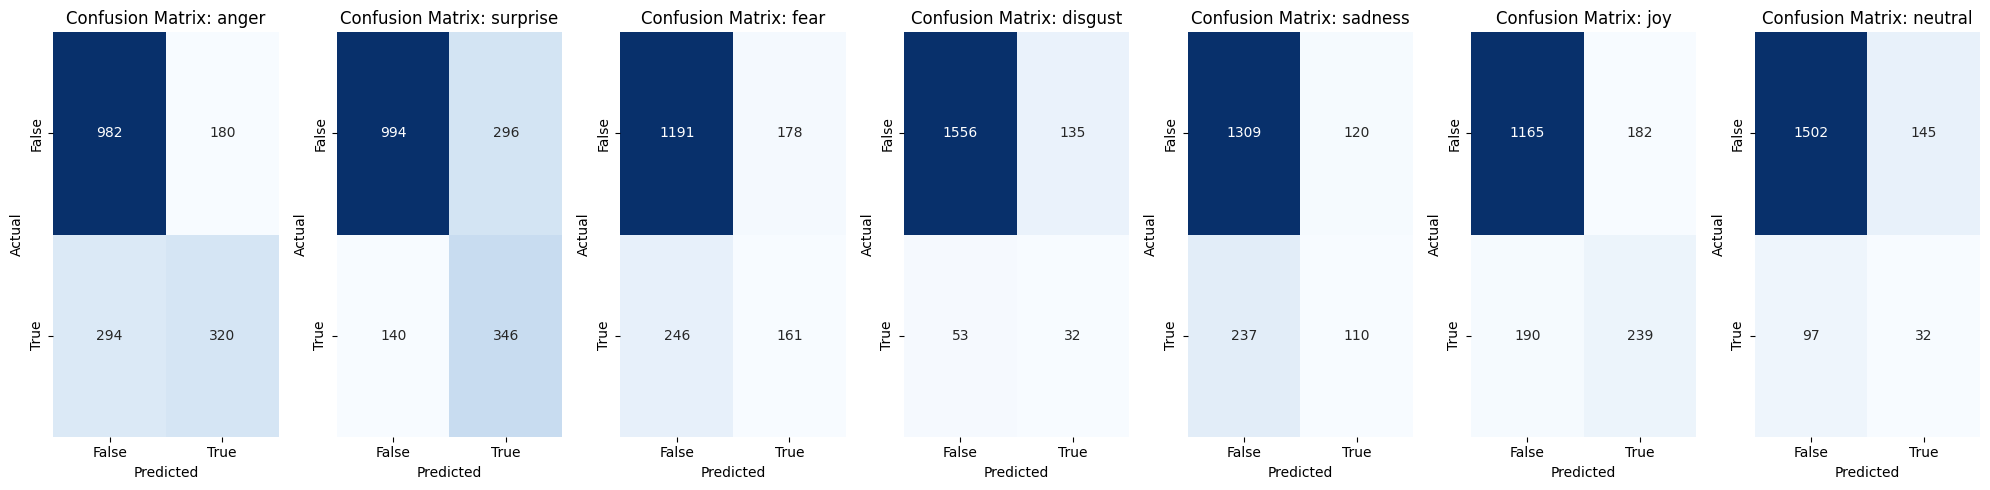

In [11]:
plot_confusion_matrices(true_matrix, predicted_matrix, all_labels)